# NeuroDevDiff — V1.0

This notebook generates **NeuroDevDiff v1**: synthetic pediatric neurodevelopmental referral vignettes for experimenting with
AI-assisted decision support under uncertainty.

Outputs are saved under `data/` (CSV + JSONL + metadata).


Creating NeuroDevDiff…
Adding vignettes + questions…
Dataset shape: (2000, 24)

Class balance (true_profile):
true_profile
ASD                 0.185
ADHD                0.168
ANXIETY             0.160
SLD                 0.145
OCD                 0.106
SELECTIVE_MUTISM    0.084
GDD_ID              0.082
NDD_UNSPEC          0.069
Name: proportion, dtype: float64

Defer rate: 0.564  | High-risk rate: 0.044

Defer rate: 0.564
true_profile
ADHD                0.682
NDD_UNSPEC          0.580
OCD                 0.563
ANXIETY             0.555
GDD_ID              0.546
SLD                 0.541
ASD                 0.511
SELECTIVE_MUTISM    0.506
Name: should_defer, dtype: float64

Mean cognitive scores by profile:
                  cog_verbal_language  cog_visuospatial  cog_working_memory  \
true_profile                                                                  
ADHD                            10.04             10.03                7.56   
ANXIETY                          9.92        

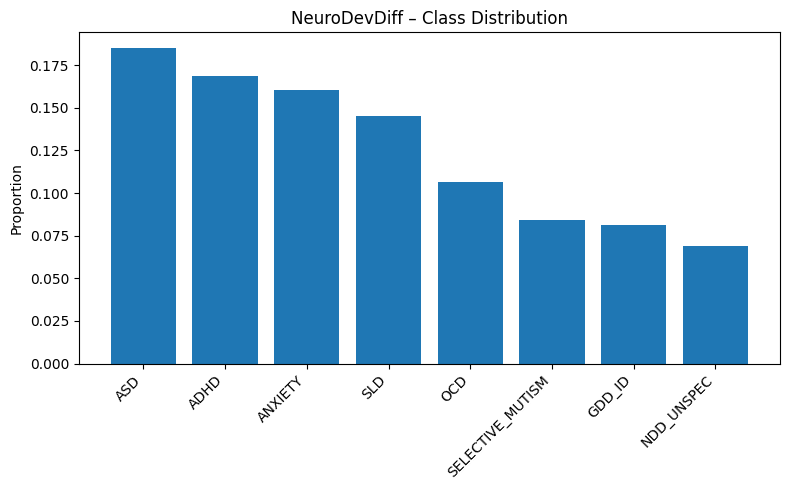

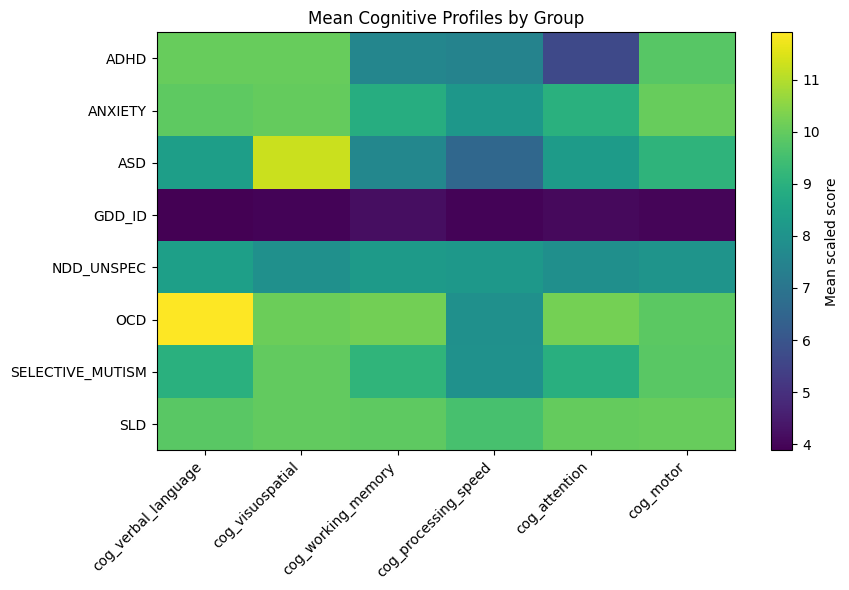

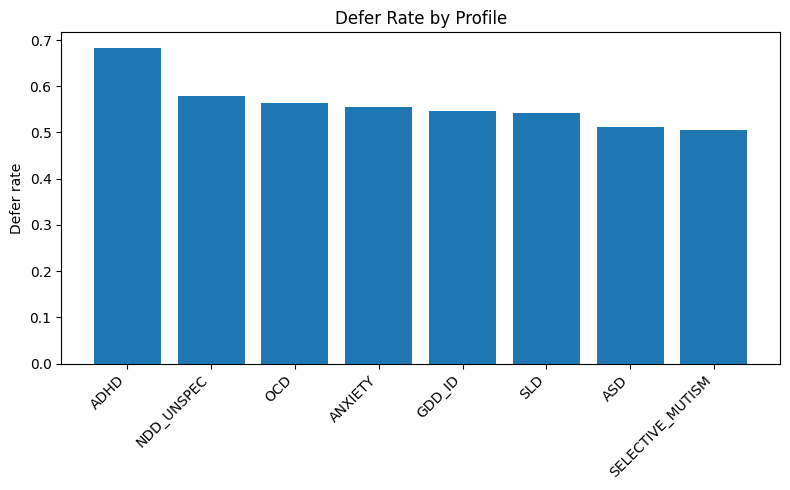

,case_id,age,sex,context,duration,severity,true_profile,comorbidity,plausible_alternatives,symptoms,...,cog_verbal_language,cog_visuospatial,cog_working_memory,cog_processing_speed,cog_attention,cog_motor,cognitive_pattern,vignette_en,questions_to_ask_en,should_defer_rationale_en
0,1,5,F,preschool,6 months,mild,ANXIETY,"ASD, SELECTIVE_MUTISM","ASD, SELECTIVE_MUTISM",anxiety:worry; school:performance fear; school...,...,10,11,9,7,8,11,dishomogeneous,A pediatric neurodevelopmental evaluation is r...,[Is a language and pragmatic communication ass...,No defer: available information supports a ten...
1,2,5,F,home+school,3 months,severe,ADHD,,"ANXIETY, ASD, SLD",school:homework incomplete; attention:inattent...,...,9,7,7,6,3,7,dishomogeneous,A pediatric neurodevelopmental evaluation is r...,[Which situations lead to the most impairment ...,Defer: missing key information (onset timeline...
2,3,9,M,home+school,1 year,severe,OCD,ASD,"ANXIETY, ASD",anxiety:intrusive thoughts; anxiety:high distr...,...,12,8,8,7,11,10,dishomogeneous,A pediatric neurodevelopmental evaluation is r...,[How do the difficulties affect daily function...,Defer: missing key information (functional imp...


In [2]:
from pathlib import Path
from src.ndd_generation import NDDConfig, generate_neurodevdiff, print_summary
from src.ndd_vignette import add_text_fields
from src.ndd_evaluation import compute_diagnostics, plot_class_distribution, plot_cognitive_heatmap, plot_defer_by_profile

SEED = 42
NOISE_LEVEL = 1.0
VERSION = "1"

cfg = NDDConfig(
    n_cases=2000,
    seed=SEED,
    noise_level=NOISE_LEVEL,
    version=VERSION,
)

print("Creating NeuroDevDiff…")
df = generate_neurodevdiff(cfg)

print("Adding vignettes + questions…")
df = add_text_fields(df, seed=cfg.seed)

print_summary(df)

print("Evaluating Data…")
diag = compute_diagnostics(df)
assets = Path("../assets")
plot_class_distribution(df, assets / "class_distribution.png")
plot_cognitive_heatmap(df, assets / "cognitive_profiles.png")
plot_defer_by_profile(df, assets / "defer_by_profile.png")


df.head(3)

In [3]:
from src.ndd_export import make_splits, export_bundle

DATA_DIR = Path("../data")

print("Splitting train/val/test…")
train_df, val_df, test_df = make_splits(df, seed=SEED, stratify_col="true_profile")
print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

print("Exporting CSV/JSONL/metadata…")
paths = export_bundle(
    df=df,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    out_dir=DATA_DIR,
    version=VERSION,
    seed=SEED,
    noise_level=NOISE_LEVEL,
    cfg=cfg,          # per salvare anche config nel metadata
    verbose=True
)

Splitting train/val/test…
Train: (1399, 24) Val: (300, 24) Test: (301, 24)
Exporting CSV/JSONL/metadata…
✅ Saved bundle to: /Users/galvari/Desktop/RandomJobs/NDD/NeuroDevDiff/data
  - full_csv: neurodevdiff_v1_full.csv
  - train_csv: neurodevdiff_v1_train.csv
  - val_csv: neurodevdiff_v1_val.csv
  - test_csv: neurodevdiff_v1_test.csv
  - vignettes_jsonl: neurodevdiff_v1_vignettes.jsonl
  - train_jsonl: neurodevdiff_v1_train.jsonl
  - val_jsonl: neurodevdiff_v1_val.jsonl
  - test_jsonl: neurodevdiff_v1_test.jsonl
  - metadata_json: neurodevdiff_v1_metadata.json
